http://www.bigdataschool.ru

<img src="logo.png" align="right">

# Использование памяти в запросах Trino

<hr style="border:2px solid #294A70"> </hr>

<h3 style="color: #294A70">Практические материалы</h3>

<div style="color:red; text-align: right"> Версия 1.03 от 3 апреля 2025 </div>

In [17]:
from trsql_h import _psql, _sql

In [18]:
import vis_trino as vt

## Запросы

Попробуем "искусственно" довести ситуацию до той, когда запрос не может сохранить результаты в памяти и будет падать

### Простой запрос

In [19]:
qBase = """
select -- qq_base
    'sum' as what, ss_ticket_number, sum(ss_quantity)
from 
    hive.tpcds10part.store_sales 
group by 1,2
"""

In [22]:
_psql(f"explain analyze {qBase}")

QUERY ID: 20250521_151756_00003_46wqm


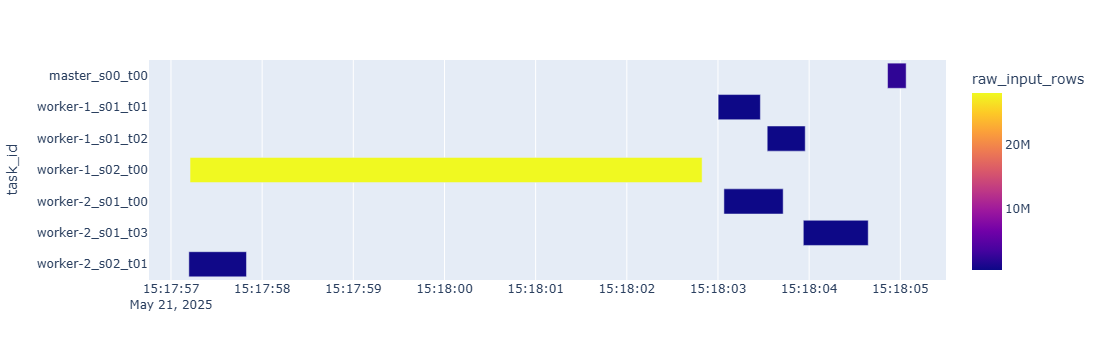

In [23]:
vt.drawQuery("","qq_base", True)

In [ ]:
vt.RESDF.sort_values(by='task_id', ascending=True)

Что происходит

* s02: читается таблица чеков и производится локальная агрегация
    * worker-2_s02_t01 читает свою часть таблицы чеков
    * worker-1_s02_t00 читает свою часть таблицы чеков
    * распределение количества строк - сильно разное (силнее, чем без fault tolerance)
* s01: производится глобальная агрегация, результаты отдаются координатору (все 2400000 строк)
    * это делается несколькими тасками
 
С точки зрения использования памяти: на каждом узле память освобождается после окончания стадии (это на глаз незаметно, но общая нагрузка на кластер по памяти сильно меньше, чем без fault tolerance)

По общему времени - получается чуть дольше, чем без fault tolerance (4+ секунды против 3+).

### Чуть усложним запрос

In [24]:
qUn1 = """
select -- qq_un1
    'sum' as what, ss_ticket_number, sum(ss_quantity)
from 
    hive.tpcds10part.store_sales 
group by 1,2
union 
select 
    'avg' as what, ss_ticket_number, avg(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2
"""

In [25]:
_psql(f"explain analyze {qUn1}")

QUERY ID: 20250521_151933_00006_46wqm


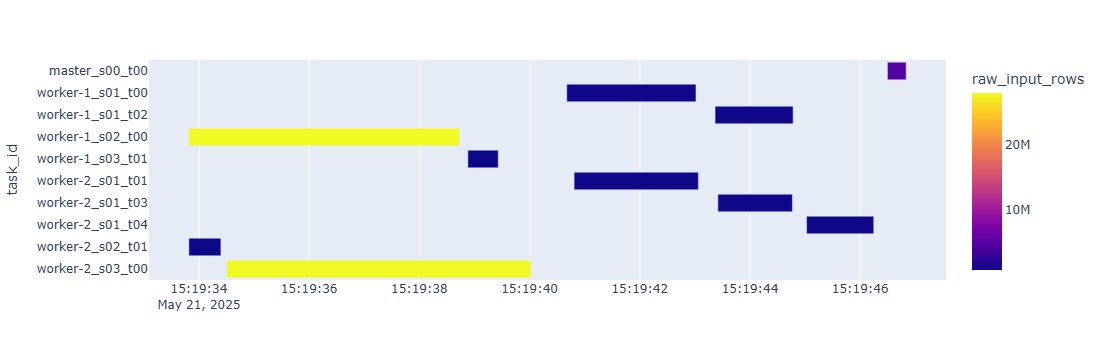

In [26]:
vt.drawQuery("","qq_un1", True)

In [ ]:
vt.RESDF.sort_values(by='task_id', ascending=True)

Наблюдения здесь:

* s03: читаем таблицу и вычисляем частичный агрегат (avg)
    * распределение пропорции разбиения таблицы на части стабильно (возможно, это из-за паркета, хотя там 4 примерно одинаковых файла): 28028847 и 772144
    * имеет место перекос (части сильно не равны)
    * иногда таски этой стадии оказываются на одном воркере
* s02: еще раз читаем таблицу и вычисляем другой частичный агрегат (sum)
    * аналогично (про распределение и про исполнение на одном воркере) 
* s01: вычисление окончательного агрегата и отдача результата мастеру

Памяти требуется больше, чем предыдущему запросу, но не сравнить с без fault tolerance

По общему времени - получается чуть дольше, чем без fault tolerance (10+ секунды против 9+).

### Еще чуть усложним запрос

In [27]:
qUn2 = """
select -- qq_un2
    'sum' as what, ss_ticket_number, sum(ss_quantity)
from 
    hive.tpcds10part.store_sales 
group by 1,2
union 
select 
    'avg' as what, ss_ticket_number, avg(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2
union 
select 
    'min' as what, ss_ticket_number, min(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2
"""

In [28]:
_psql(f"explain analyze {qUn2}")

QUERY ID: 20250521_152223_00009_46wqm


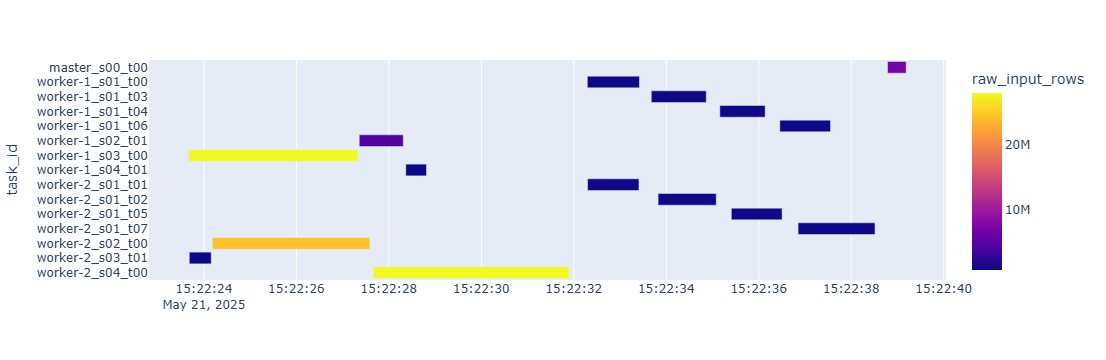

In [29]:
vt.drawQuery("","qq_un2", True)

Наблюдения здесь:

* тоже перекос в операции чтения
    * worker-1 прочитал почти полностью таблицу дважды
    * worker-2 один раз и два "хвостика"
* немного перекос в вычислениях
    * бОльше пришлось аггрегировать worker-2 (получал данные из S3)

По ощущениям - чуть бОльший "простой" worker-2 (пока дочитывал свое worker-1).

Не очень понятно, почему не стадия 1 не начинается сразу после окончания стадии 2 - данные для окончательной агрегации есть, чего ждем?

По памяти: каждая стадия пишет в S3, поэтому памяти бывает нужно много (относительно) только тогда, когда стадии "пересекаются" по времени (напнимер 2 и 3 стадии выполнялись одновременно).

По общей продолжительности - примерно то же, что и без fault tolerance.

### Максимально возможное усложнение запроса

В варианте с fault tolerance это - не максимально возможное усложнение (по памяти еще есть достаточно большой резерв).

In [30]:
qUn3 = """
select -- qq_un3
    'sum' as what, ss_ticket_number, sum(ss_quantity)
from 
    hive.tpcds10part.store_sales 
group by 1,2
union 
select 
    'avg' as what, ss_ticket_number, avg(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2
union 
select 
    'min' as what, ss_ticket_number, min(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2
union 
select 
    'max' as what, ss_ticket_number, max(ss_quantity)
from 
    hive.tpcds10part.store_sales
group by 1,2

"""

In [31]:
_psql(f"explain analyze {qUn3}")

QUERY ID: 20250521_152342_00012_46wqm


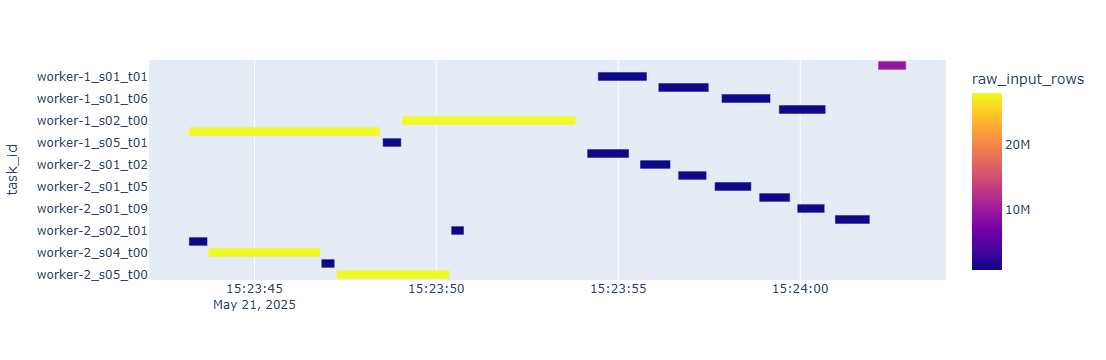

In [32]:
vt.drawQuery("","qq_un3", True)

In [33]:
_psql(f"explain analyze select * from hive.tpcds10part.store_sales order by ss_ticket_number")

May 21, 2025 3:26:14 PM org.jline.utils.Log logr
Query 20250521_152615_00015_46wqm failed: Cannot allocate enough memory for task 20250521_152615_00015_46wqm.1.0.0. Reported peak memory reservation: 1503297157B. Maximum possible reservation: 1503238554B.




## Параллельный запуск (ака "нагрузочное тестирование")

Будем запускать один и тот же запрос параллельно - посмотрим, на сколько "хватит" нашего кластера

Видно, что в таком варианте память не является узким местом (скорее всего, тормозит и держит сеть во время exchange) - временами на графике в ВЭБ интерфейсе объем занятой памяти достаточно долго (относительно) =0...

Координатор во время выполнения 20 запросов почти ничего не делает, воркер занять в среднем на 75% (top).

Время выполнения отдельно взятого запроса кратно растет (например, 130 секунд на запрос при 10 запросах, 260 секунд - при 20 запросах)

In [34]:
import load_test as lt

### Максимально возможное усложнение запроса

In [37]:
pList = lt.startQueries("explain analyze " + qUn3,3,"un3_3")

In [ ]:
pList

In [36]:
!grep "END::un3_3" log_load.txt

END::un3_3_0::True::41.13184309005737::2025-05-21 15:28:43.202832::2025-05-21 15:29:24.334662
END::un3_3_1::True::43.147088050842285::2025-05-21 15:28:43.210331::2025-05-21 15:29:26.357402
END::un3_3_2::True::44.96228075027466::2025-05-21 15:28:43.219032::2025-05-21 15:29:28.181281


In [ ]:
!grep "END::un3_6_" log_load.txt

In [ ]:
!grep "END::un3_10_" log_load.txt

In [ ]:
!grep "END::un3_20_" log_load.txt